<b>1</b> OBTENCIÓN DE DATOS

In [37]:
import definirCorrelacionVariables
from matplotlib import pyplot
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl

data= definirCorrelacionVariables.getDataFromDataBase()

<b>2</b> pre PROCESAMIENTO DE DATA

In [38]:
dataframe,datos,dictGeneral = definirCorrelacionVariables.generarMatrizDatos(data,True)

373


3. OBTENCIÓN DE CORRELACIÓN MÚLTIPLE

GRAFICAS ENTRE VARIABLES

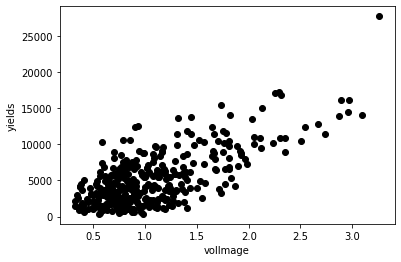

In [39]:
#pyplot.scatter(datos.datosVolumen, datos.datosVolumenCalculado,c="red")
#pyplot.scatter(datos.datosArea, datos.datosAreaCalculada,c="red")
#pyplot.scatter(datos.datosNdvi, datos.datosVolumenCalculado,c="blue")
#pyplot.scatter(datos.datosAltura, datos.datosNdvi,c="green")
pyplot.scatter(dataframe["volImage"],dataframe["yields"],c="black")
pyplot.xlabel("volImage")
pyplot.ylabel("yields")

pyplot.show()

SE CALCULA LA VARIABLE EL IAF
$Ac = \pi*r*g $

$g = \sqrt(h^2 + r^2) $

Se tiene que $r = Di/2$

$Ac = \pi*r*\sqrt(h^2 + r^2)$

$Ac = \pi*\frac{Di}{4}*\sqrt(4*h^2 + Di^2)$

Diametro

$diameter = 2*\sqrt(\frac{area}{\pi})$

In [40]:

import math
areaLateral = []
volumeFromDiameter = []
diametros=[]
for index,x in enumerate(datos.datosArea):
    diametro = 2*math.sqrt(x/math.pi)
    diametros.append(diametro)
    altura= datos.datosAlturaCalculada[index]/100
    valueAreaLateral=diametro*math.sqrt((diametro*diametro)+4*(altura*altura))
    valueVolume = math.pi*diametro*diametro*altura*(1/6)
    volumeFromDiameter.append(valueVolume)
    areaLateral.append(valueAreaLateral)


<b style="color:orange;">LAI CALCULATED FROM EQUATION BASED ON VOLUME and AREA</b>

Se calcula el IAF usando Volumen Imagen y Yield

$IAF =  0.0134 + 2.7791 Vc$

Se calcula IAF usando Area Lateral y Yield

$IAF =  -0.5786 + 0.7896 Alat $


In [41]:

IAF_from_volume = definirCorrelacionVariables.objective(datos.datosVolumenImagen, 2.7791,0.0134)
IAF_from_area = definirCorrelacionVariables.objective(areaLateral, 0.7896,-0.5786)
d = {"latArea":areaLateral, "IAF_VOL":IAF_from_volume, "laiLatArea":IAF_from_area}
dictGeneral.update(d)
dframeFinal = pd.DataFrame(data=dictGeneral)
pd.options.display.float_format = '{:,.2f}'.format
dataFrameCorrs=dframeFinal.loc[:,["yields","volImage","criMax","laiLatArea","hImage","tviMin","ndviMax","cgreenviMax"]]
dfCors= dataFrameCorrs.corr(method="pearson")
dfCors.round(decimals=3)
print(dfCors)
dfCors.to_latex("CorrelationsTab.tex")

             yields  volImage  criMax  laiLatArea  hImage  tviMin  ndviMax  \
yields         1.00      0.71    0.63        0.69    0.50   -0.39     0.55   
volImage       0.71      1.00    0.62        0.99    0.69   -0.46     0.60   
criMax         0.63      0.62    1.00        0.61    0.40   -0.65     0.63   
laiLatArea     0.69      0.99    0.61        1.00    0.74   -0.45     0.58   
hImage         0.50      0.69    0.40        0.74    1.00   -0.39     0.27   
tviMin        -0.39     -0.46   -0.65       -0.45   -0.39    1.00    -0.30   
ndviMax        0.55      0.60    0.63        0.58    0.27   -0.30     1.00   
cgreenviMax    0.60      0.60    0.91        0.60    0.36   -0.55     0.67   

             cgreenviMax  
yields              0.60  
volImage            0.60  
criMax              0.91  
laiLatArea          0.60  
hImage              0.36  
tviMin             -0.55  
ndviMax             0.67  
cgreenviMax         1.00  


<h1> USO DE CROSS VAL SCORE </h1>

<b style="color:red;">LINEAR REGRESSION SIMPLE VS MULTIPLE</b>




Non Standard Scaler

REGRESSION MODELS

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,MaxAbsScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.isotonic import IsotonicRegression
from sklearn.cross_decomposition import PLSRegression

cantCv=4
scoreDef = "r2" 
#scoreDef="accuracy"
#scoreDef = "explained_variance"
#scoreDef="neg_root_mean_squared_error"
dfsX=dframeFinal.loc[:,["volImage"]]
dframeFinal.head()
X_volumenNoScaled= dfsX.values
y_multiple = dframeFinal.yields.values

sc_X = MaxAbsScaler()
sc_y = MaxAbsScaler()
Xvolume = sc_X.fit_transform(X_volumenNoScaled)
yieldNoScaled=dframeFinal.yields.values.reshape(-1, 1)
y = sc_y.fit_transform(yieldNoScaled)
#y=y+1
#print(y)
dfsX=dframeFinal.loc[:,["volImage","maxRed","maxBlue","varianceBlue","mtviOneMean",'ndviMean','laiLatArea','saviMax','tviMax','ndviMax']]
X_multipleNoScaled= dfsX.values
sc_XMulti = MaxAbsScaler()
Xmulti = sc_XMulti.fit_transform(X_multipleNoScaled)

scores = cross_val_score(LinearRegression(),X_volumenNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "Linear Regression Simple",scores)
print(np.mean(scores))

scores = cross_val_score(LinearRegression(),X_multipleNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "Linear Regression Multiple",scores)
print(np.mean(scores))

scores = cross_val_score(PLSRegression(),X_volumenNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "PLSRegression Regression Simple",scores)
print(np.mean(scores))

scores = cross_val_score(PLSRegression(),X_multipleNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "PLSRegression Regression Multiple",scores)
print(np.mean(scores))

scores = cross_val_score(SVR(kernel="linear"),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR Linear Simple",scores)
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))
scores = cross_val_score(SVR(kernel="linear"),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR Linear Multiple",scores,np.mean(scores.reshape(-1,1)))
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(RandomForestRegressor(),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("Simple Regressor Random forest  ")
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(RandomForestRegressor(),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("Multi Regressor Random Forest ")
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(tree.DecisionTreeRegressor(),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Decision Tree Simple Regressor")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(tree.DecisionTreeRegressor(),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Decision Tree Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(linear_model.SGDRegressor(loss="squared_epsilon_insensitive"),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("SGD Simple Regressor Squared Error")
#print(scores)
#scores=scores-1
print(np.mean(scores))

print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(linear_model.SGDRegressor(loss="squared_error",penalty="elasticnet",learning_rate="adaptive"),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("SGD Multi Regressor Squared Error")
#print(scores)
#scores=scores-1
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(linear_model.Lasso(),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Lasso Simple Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(linear_model.Lasso(),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Lasso Multi Regressor ")
#print(scores)
print(np.mean(scores))



scores = cross_val_score(ensemble.BaggingRegressor(),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("BaggingRegressor Simple Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.BaggingRegressor(),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("BaggingRegressor Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.AdaBoostRegressor(loss="square"),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("AdaBoostRegressor Single Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.AdaBoostRegressor(loss="square"),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("AdaBoostRegressor Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.ExtraTreesRegressor(criterion="absolute_error"),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("ExtraTreesRegressor Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(SVR(kernel="rbf"),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR RBF Simple",scores)
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(SVR(kernel="rbf"),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR RBF Multiple",scores)
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

Linear Regression Simple [0.5592212  0.55552891 0.45958938 0.33793399]
0.4780683693718533
Linear Regression Multiple [0.62686969 0.69602747 0.60166878 0.3820259 ]
0.5766479605021491
PLSRegression Regression Simple [0.5592212  0.55552891 0.45958938 0.33793399]
0.4780683693718534
PLSRegression Regression Multiple [0.61116547 0.68741189 0.47818272 0.38396173]
0.54018044881801
SVR Linear Simple [0.55979283 0.54629375 0.44994736 0.33963099]
0.4739162326871408
-13154.418041818124
SVR Linear Multiple [0.608537   0.67332593 0.4835525  0.39260221] 0.5395044085056806
0.5395044085056806
-14974.938681985572


c:\Users\Julian Bolanos\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\cross_decomposition\_pls.py:236: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
c:\Users\Julian Bolanos\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\cross_decomposition\_pls.py:236: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
c:\Users\Julian Bolanos\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\cross_decomposition\_pls.py:236: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
c:\Users\Julian Bolanos\AppData\Local\Programs\Pytho

Simple Regressor Random forest  
0.22906312395684525
-6358.068963808477
Multi Regressor Random Forest 
0.5120797953619572
-14213.718025157317
Decision Tree Simple Regressor
-0.05292267783533558
Decision Tree Multi Regressor 
0.14168661306850416
SGD Simple Regressor Squared Error
0.11013470779072898
-3056.991694456561
SGD Multi Regressor Squared Error
0.5183490449153108
-14387.732595128244
Lasso Simple Regressor 
0.47808555159038857
Lasso Multi Regressor 
0.5511737320502967
BaggingRegressor Simple Regressor 
0.19248012120126898
BaggingRegressor Multi Regressor 
0.466293223274056
AdaBoostRegressor Single Regressor 
0.2789988339610514
AdaBoostRegressor Multi Regressor 
0.4539326412129665
ExtraTreesRegressor Multi Regressor 
0.5082614248120236
SVR RBF Simple [0.49840474 0.55177745 0.42584624 0.31780287]
0.4484578263399037
-12447.773076586234
SVR RBF Multiple [0.65023105 0.66439384 0.50298673 0.37504143]
0.5481632632270905
-15215.281145300158
